# Question 1: Multi Layer Perceptron


## Task :

<ul>
<li>Train MLP for MNIST</li>
<li>Knowledge Distillation</li>
</ul>


# Data Preprocessing


<img src="Images/Q4-prep.png" width = 500>


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow import keras

# scikit-learn for clustering
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

import seaborn as sns
import torchvision


### 1. Load data set / report the number and dimensions of training and test data


In [10]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False)


In [11]:
num_train_samples = len(train_dataset)
train_data_dimensions = train_dataset[0][0].shape

num_test_samples = len(test_dataset)
test_data_dimensions = test_dataset[0][0].shape

print("Training Data:")
print(f"Number of Samples: {num_train_samples}")
print(f"Data Dimensions: {train_data_dimensions}")

print("\nTest Data:")
print(f"Number of Samples: {num_test_samples}")
print(f"Data Dimensions: {test_data_dimensions}")


Training Data:
Number of Samples: 60000
Data Dimensions: torch.Size([1, 28, 28])

Test Data:
Number of Samples: 10000
Data Dimensions: torch.Size([1, 28, 28])


### 2. Show an example of each class


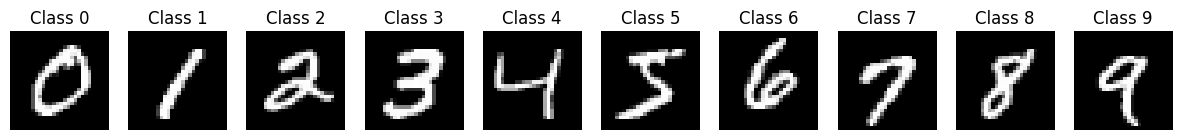

In [16]:

class_shown = {}

fig, axs = plt.subplots(1, 10, figsize=(15, 2))

for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    label = int(label)
    if label not in class_shown:
        ax = axs[label]
        ax.imshow(image[0], cmap='gray')
        ax.set_title(f'Class {label}')
        ax.axis('off')
        class_shown[label] = True

    if len(class_shown) == 10:
        break

plt.show()


### 3. Draw histogram chart for training data


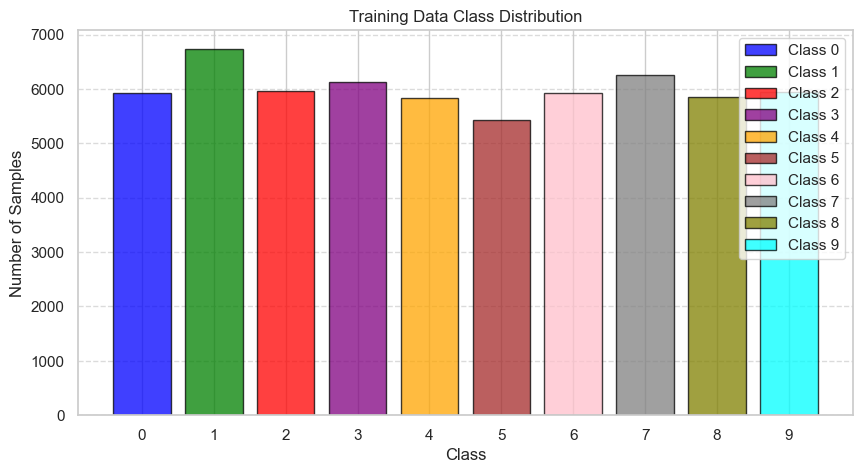

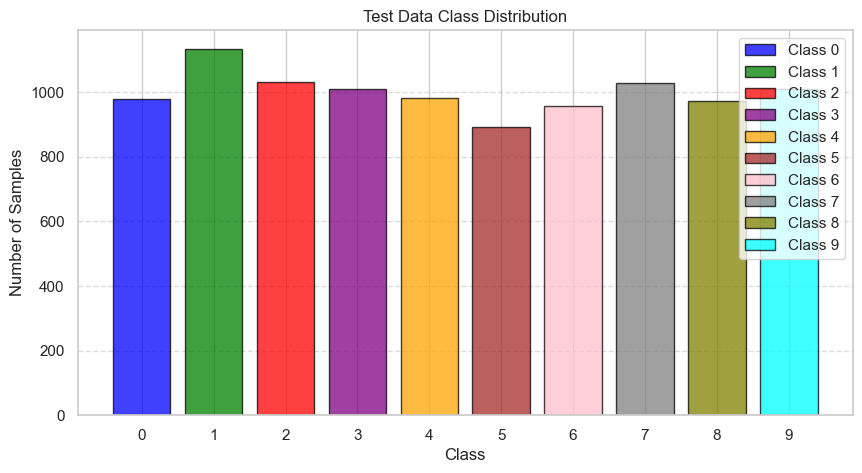

In [19]:
colors = ['blue', 'green', 'red', 'purple', 'orange',
          'brown', 'pink', 'gray', 'olive', 'cyan']


def plot_class_histogram(dataset, title):
    labels = [int(label) for _, label in dataset]
    unique_labels = list(set(labels))

    plt.figure(figsize=(10, 5))
    for i, label in enumerate(unique_labels):
        color = colors[i % len(colors)]
        plt.hist(
            [label for label in labels if label == unique_labels[i]],
            bins=[unique_labels[i] - 0.5, unique_labels[i] + 0.5],
            align='mid',
            rwidth=0.8,
            alpha=0.75,
            edgecolor='black',
            color=color,
            label=f'Class {unique_labels[i]}'
        )

    plt.xticks(range(10))
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='best')


# Plot the histogram for the training data
plot_class_histogram(train_dataset, title="Training Data Class Distribution")
plt.show()

# Plot the histogram for the test data
plot_class_histogram(test_dataset, title="Test Data Class Distribution")
plt.show()


### 4. Scaling using min-max normalization


In [24]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(
        lambda x: (x - x.min()) / (x.max() - x.min()))
])

train_dataset_normalized = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)
train_loader_normalized = torch.utils.data.DataLoader(
    train_dataset_normalized, batch_size=64, shuffle=True)

test_dataset_normalized = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)
test_loader_normalized = torch.utils.data.DataLoader(
    test_dataset_normalized, batch_size=64, shuffle=False)


---


## Teacher Network
